In [42]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions

import importlib
importlib.reload(gedi_pipeline)

2023-06-04 23:41:16,099 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.gedi_pipeline' from '/home/jk871/fire-regen/src/data/gedi_pipeline.py'>

In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

### Prep the data

In [4]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")

In [5]:
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2019', '2020', '2021', '2022']).filter_within_geometry(sierras)

In [13]:
sierra_firep.perimeters = sierra_firep.perimeters.drop(columns='index_right')

In [6]:
burn_severity_2019 = mtbs.get_burn_severity_data().sort('system:time_start', True).filterDate('2019', '2020').first()
burn_severity_2020 = mtbs.get_burn_severity_data().sort('system:time_start', True).filterDate('2020', '2021').first()
burn_severity_2021 = mtbs.get_burn_severity_data().sort('system:time_start', True).filterDate('2021', '2022').first()

In [7]:
gedi_gpd = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
print(f'Total number of GEDI shots available for the region: {gedi_gpd.shape[0]}')

Total number of GEDI shots available for the region: 15628961


In [8]:
gedi_all = gedi_pipeline.process_shots(gedi_gpd)
gedi_burned, gedi_unburned = gedi_pipeline.filter_shots(gedi_all)
gedi_burned_perfect = gedi_burned[gedi_burned.burn_severity_std==0]
gedi_unburned_perfect = gedi_unburned[(gedi_unburned.burn_severity_std==0) & (gedi_unburned.burn_severity_mean == 0)]

2023-06-04 23:14:17,764 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-04 23:14:18,305 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-04 23:14:20,647 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:69]


In [9]:
gedi_burned_perfect = gedi_burned[gedi_burned.burn_severity_std==0]
gedi_unburned_perfect = gedi_unburned[(gedi_unburned.burn_severity_std==0) & (gedi_unburned.burn_severity_mean == 0)]

In [10]:
print(gedi_burned.shape[0], gedi_burned_perfect.shape[0])
print(gedi_unburned.shape[0], gedi_unburned_perfect.shape[0])

2184975 1389748
12539296 12539296


In [18]:
def find_matches(left, right, column):
    closest_indeces, distances = k_nn.nearest_neighbors(left, right, 1)

    result = left.copy()
    result[f'{column}_after'] = right.iloc[closest_indeces.flatten()][column].values
    result['closest_distance'] = distances
    result[f'{column}_diff'] = result[column] - result[f'{column}_after']
    return result

In [27]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

### Analysis of a single fire - CREEK

In [14]:
creek_fire = sierra_firep.get_fire('CREEK')

In [23]:
gedi_creek_before = gedi_burned_perfect[gedi_burned_perfect.absolute_time < creek_fire.alarm_date].sjoin(creek_fire.fire, how="inner", predicate="within")
gedi_creek_after = gedi_burned_perfect[(gedi_burned_perfect.absolute_time > creek_fire.cont_date) & (gedi_burned_perfect.absolute_time < creek_fire.cont_date + pd.DateOffset(months=12))].sjoin(creek_fire.fire, how="inner", predicate="within")

In [24]:
gedi_creek_matches = find_matches(gedi_creek_before, gedi_creek_after, 'pai')

In [29]:
gedi_creek_matches = filter_land_cover(gedi_creek_matches)

In [31]:
def get_closest_matches(df, distance):
    return df[df.closest_distance < distance]

In [35]:
def calculate_error_for_distances(df, distance_range, column_x, column_y):
    all_r2 = []
    all_num_matches = []
    for distance in distance_range:
        matches = get_closest_matches(df, distance)
        if (matches.shape[0] == 0):
            all_r2.append(None)
            all_num_matches.append(0)
        else:
            all_r2.append(r2_score(matches[column_x], matches[column_y]))
            all_num_matches.append(matches.shape[0])

    return all_r2, all_num_matches

### Low Severity

In [30]:
low_severity = gedi_creek_matches[gedi_creek_matches.burn_severity_median == 2]

<Axes: xlabel='pai', ylabel='pai_after'>

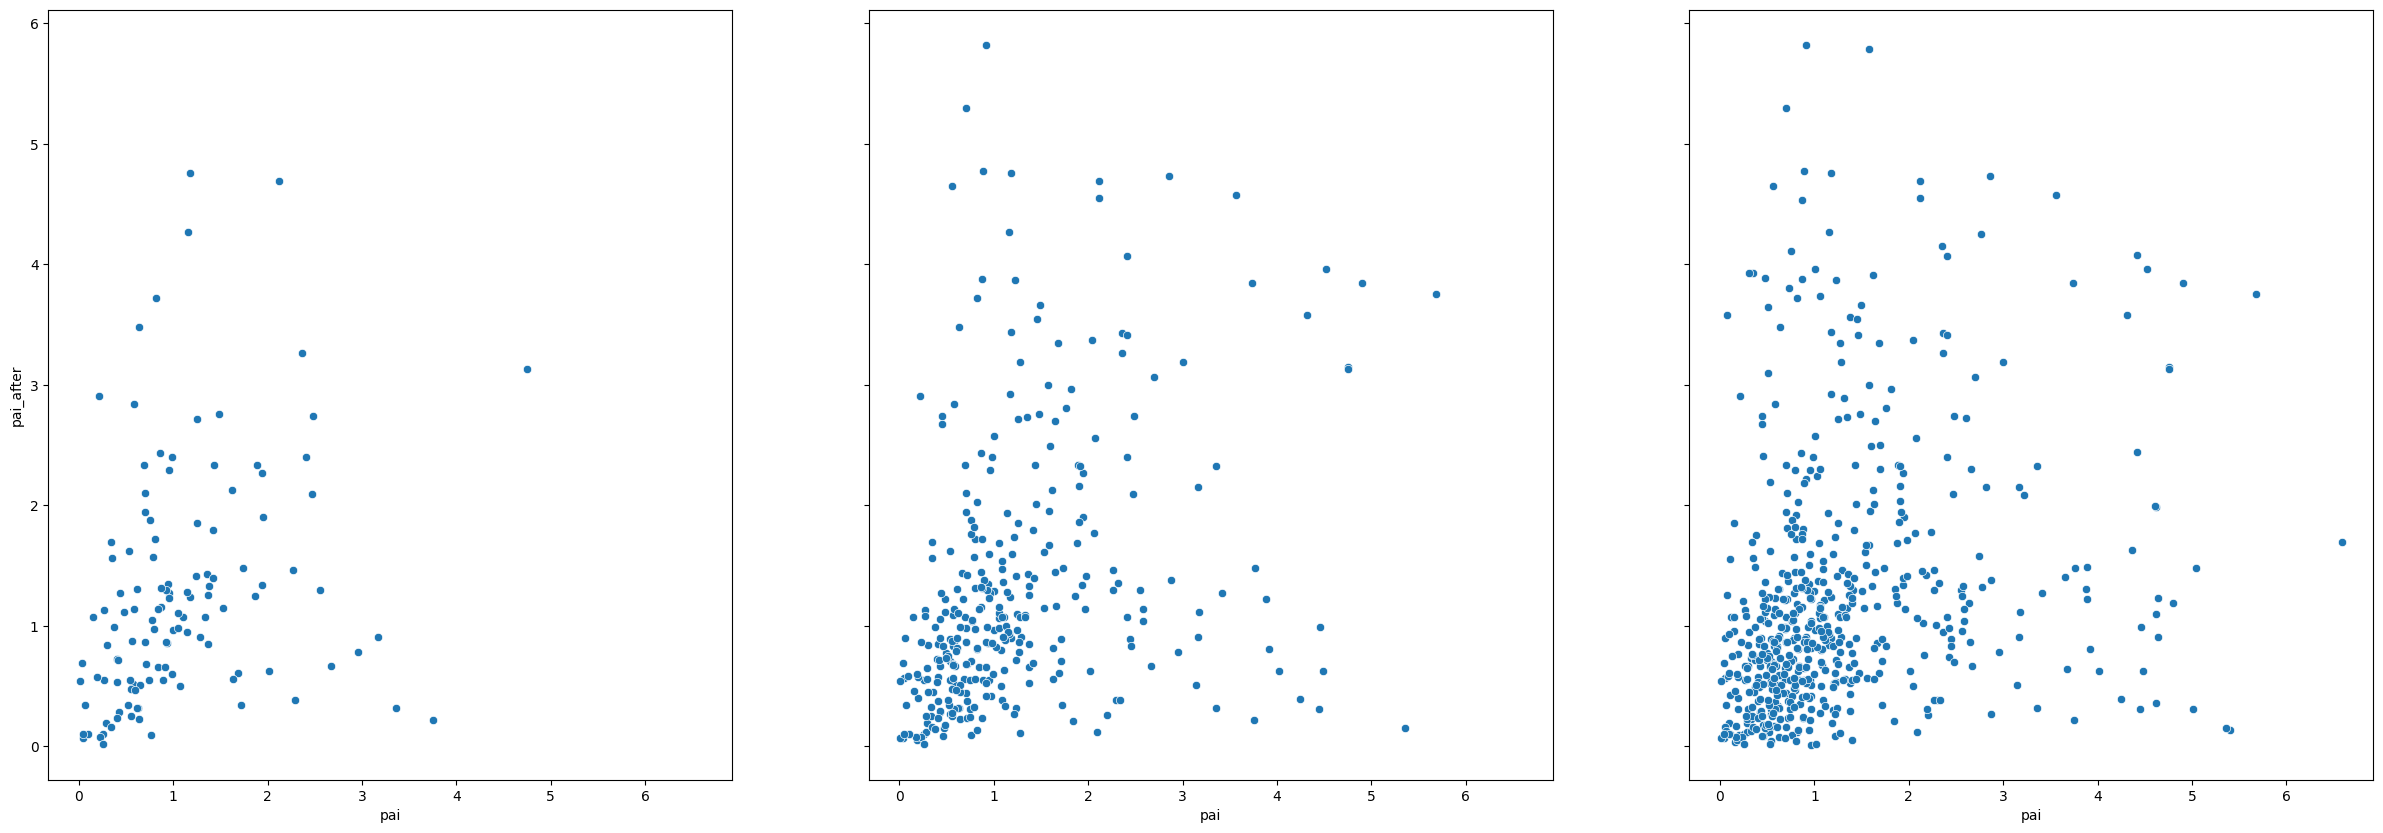

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(low_severity, 10), x='pai', y='pai_after', ax=ax[0])
sns.scatterplot(get_closest_matches(low_severity, 20), x='pai', y='pai_after',  ax=ax[1])
sns.scatterplot(get_closest_matches(low_severity, 30), x='pai', y='pai_after',  ax=ax[2])

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


<Axes: >

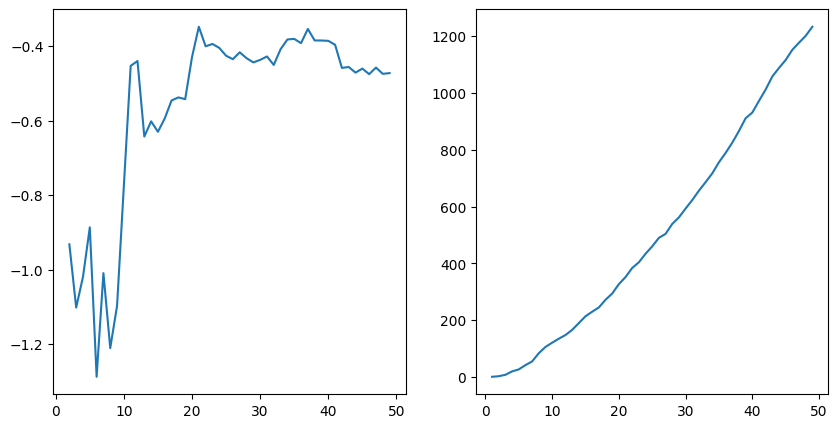

In [38]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(low_severity, distances, 'pai', 'pai_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

Best Linear regression coefficient is [0.36053513]. R squared is: 0.11325719392035016.
The error for coeff = 1 is: -0.42920312334998534.


<Axes: xlabel='pai', ylabel='pai_after'>

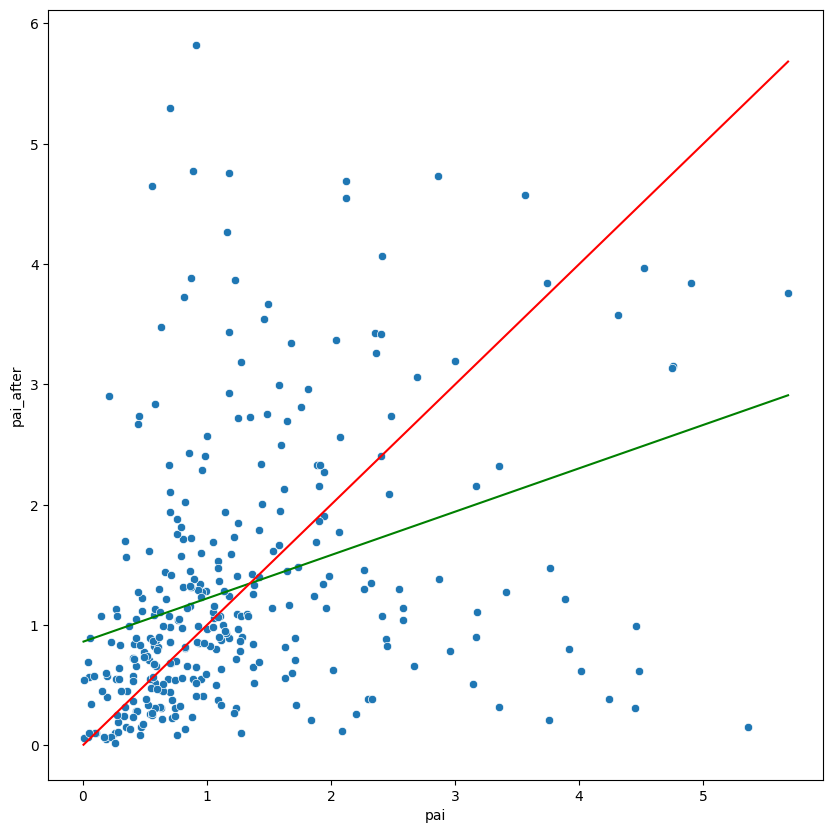

In [40]:
dist_10 = get_closest_matches(low_severity, 20)
reg_10 = LinearRegression().fit(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1)), dist_10.pai_after.values)
score = reg_10.score(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1)), dist_10.pai_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.pai.values, dist_10.pai_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(dist_10, x='pai', y='pai_after', ax=ax)
sns.lineplot(x=dist_10.pai.values, y=reg_10.predict(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.pai.values, y=dist_10.pai.values, color='red')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.984595,786.049378,-1881.023691,inf,0.126357,5.203957e-05
beta,0.984907,789.033573,-1875.130318,inf,0.127554,4.256683e-05
norm,0.985561,785.693303,-1886.493035,inf,0.128394,3.692739e-05
gamma,0.987433,783.698794,-1880.082516,inf,0.124472,7.112406e-05
burr,1.956974,539.404966,-1650.609609,inf,0.299774,1.480064e-26


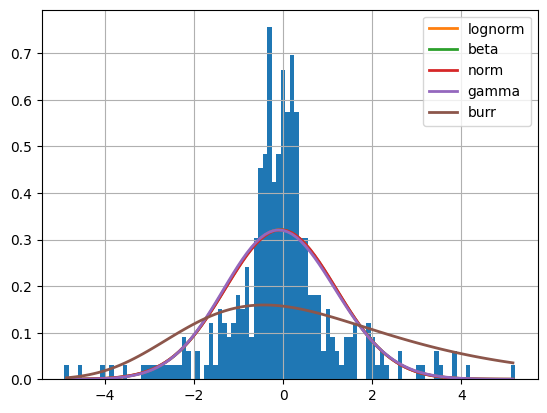

In [44]:
f = Fitter(get_closest_matches(low_severity, 20).pai_diff.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

f.fit()
f.summary()

In [46]:
# Fit normal
f = Fitter(get_closest_matches(low_severity, 20).pai_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


{'norm': {'loc': -0.052746092290519894, 'scale': 1.242558864768851}}

In [47]:
stats.wilcoxon(get_closest_matches(low_severity, 20).pai, get_closest_matches(low_severity, 20).pai_after)

WilcoxonResult(statistic=24579.0, pvalue=0.19144158668039468)

### Medium Severity

In [48]:
medium_severity = gedi_creek_matches[gedi_creek_matches.burn_severity_median == 3]

<Axes: xlabel='pai', ylabel='pai_after'>

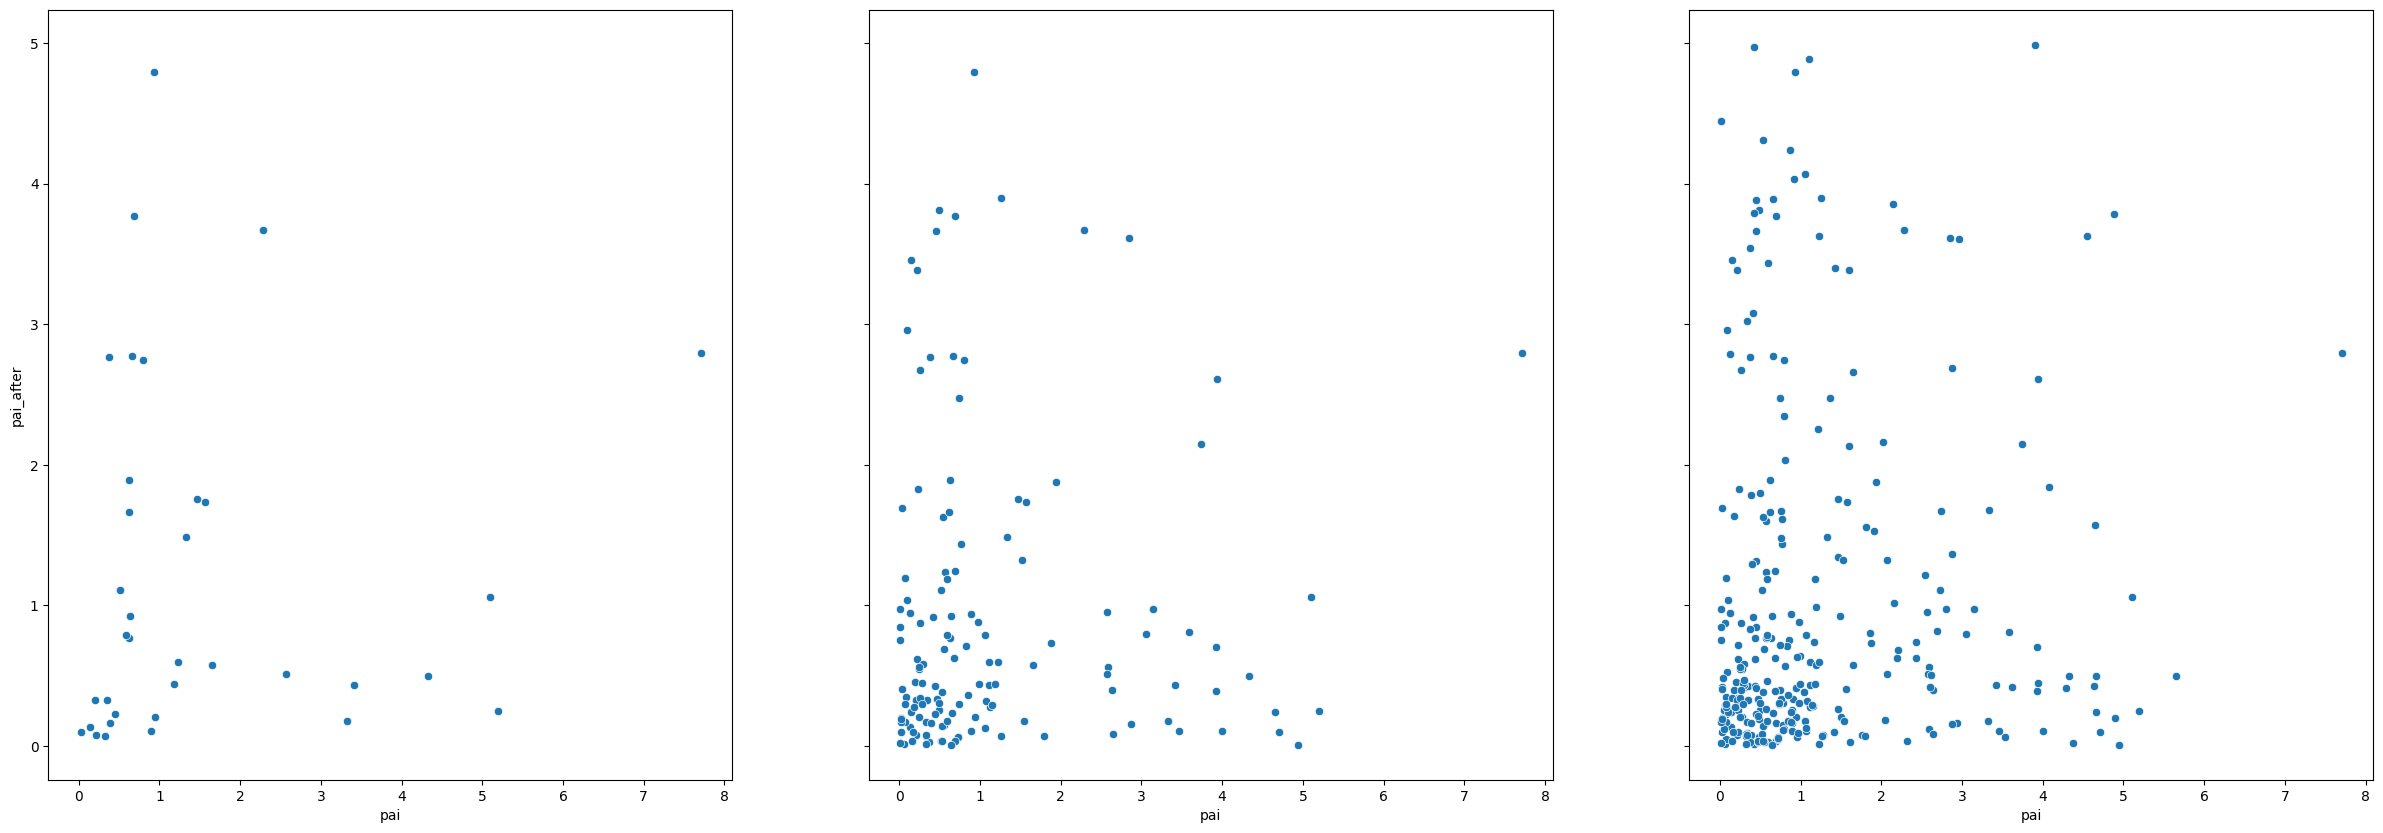

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(medium_severity, 10), x='pai', y='pai_after', ax=ax[0])
sns.scatterplot(get_closest_matches(medium_severity, 20), x='pai', y='pai_after',  ax=ax[1])
sns.scatterplot(get_closest_matches(medium_severity, 30), x='pai', y='pai_after',  ax=ax[2])

<Axes: >

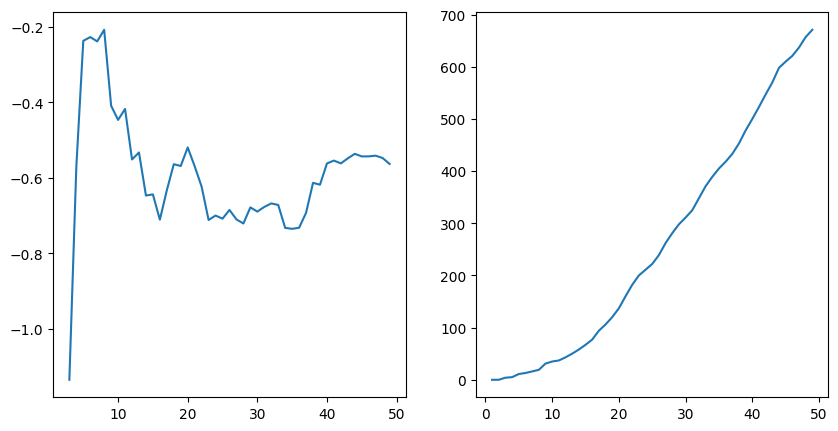

In [51]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(medium_severity, distances, 'pai', 'pai_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

Best Linear regression coefficient is [0.03656577]. R squared is: 0.0024268693387676787.
The error for coeff = 1 is: -0.5195003881292792.


<Axes: xlabel='pai', ylabel='pai_after'>

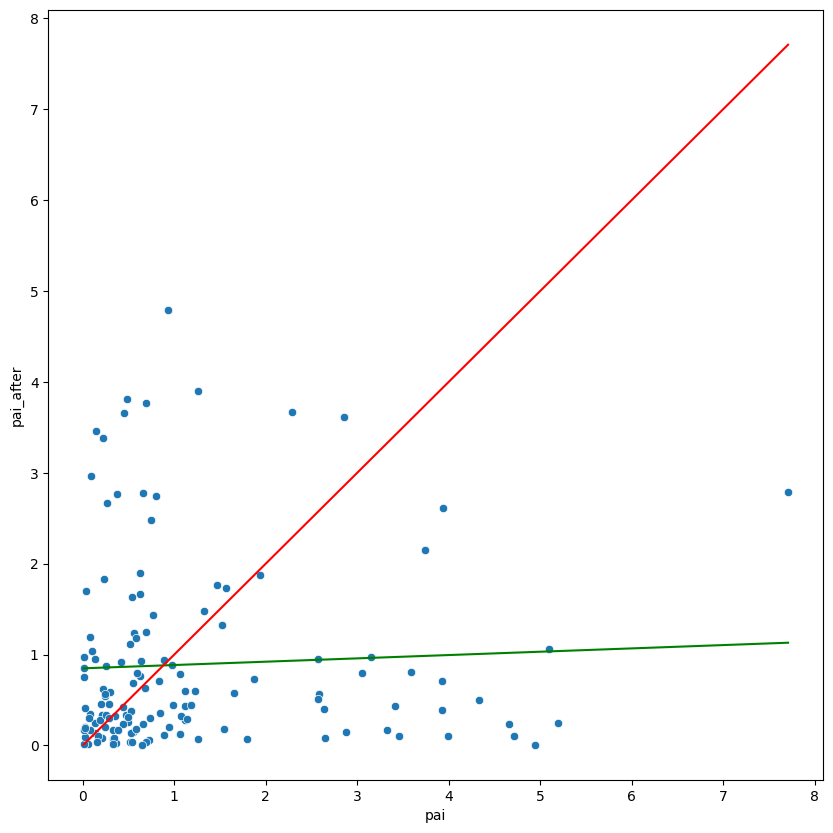

In [52]:
dist_10 = get_closest_matches(medium_severity, 20)
reg_10 = LinearRegression().fit(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1)), dist_10.pai_after.values)
score = reg_10.score(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1)), dist_10.pai_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.pai.values, dist_10.pai_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(dist_10, x='pai', y='pai_after', ax=ax)
sns.lineplot(x=dist_10.pai.values, y=reg_10.predict(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.pai.values, y=dist_10.pai.values, color='red')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,1.295722,550.718454,-618.865183,inf,0.111764,0.060313
lognorm,1.533950,524.478858,-600.662499,inf,0.130753,0.016754
gamma,1.541061,523.592836,-600.028926,inf,0.132868,0.014346
beta,1.541748,525.453011,-595.047855,inf,0.132812,0.014405
norm,1.581887,519.877968,-601.366683,inf,0.151509,0.003279


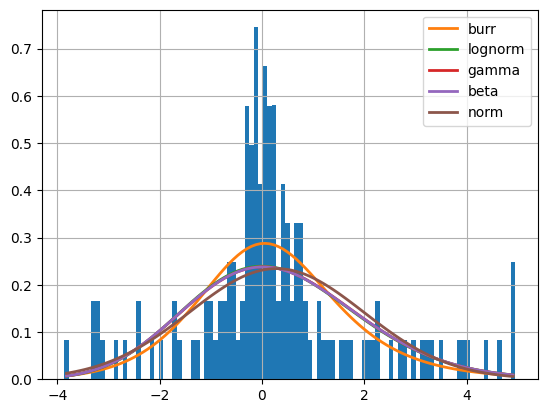

In [53]:
f = Fitter(get_closest_matches(medium_severity, 20).pai_diff.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

f.fit()
f.summary()

In [54]:
# Fit normal
f = Fitter(get_closest_matches(medium_severity, 20).pai_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 28.94it/s]


{'norm': {'loc': 0.28592943935036497, 'scale': 1.7022879261051134}}

In [56]:
stats.wilcoxon(get_closest_matches(medium_severity, 20).pai, get_closest_matches(medium_severity, 20).pai_after)

WilcoxonResult(statistic=3991.0, pvalue=0.1140526863375776)

### High Severity

In [57]:
high_severity = gedi_creek_matches[gedi_creek_matches.burn_severity_median == 4]

<Axes: xlabel='pai', ylabel='pai_after'>

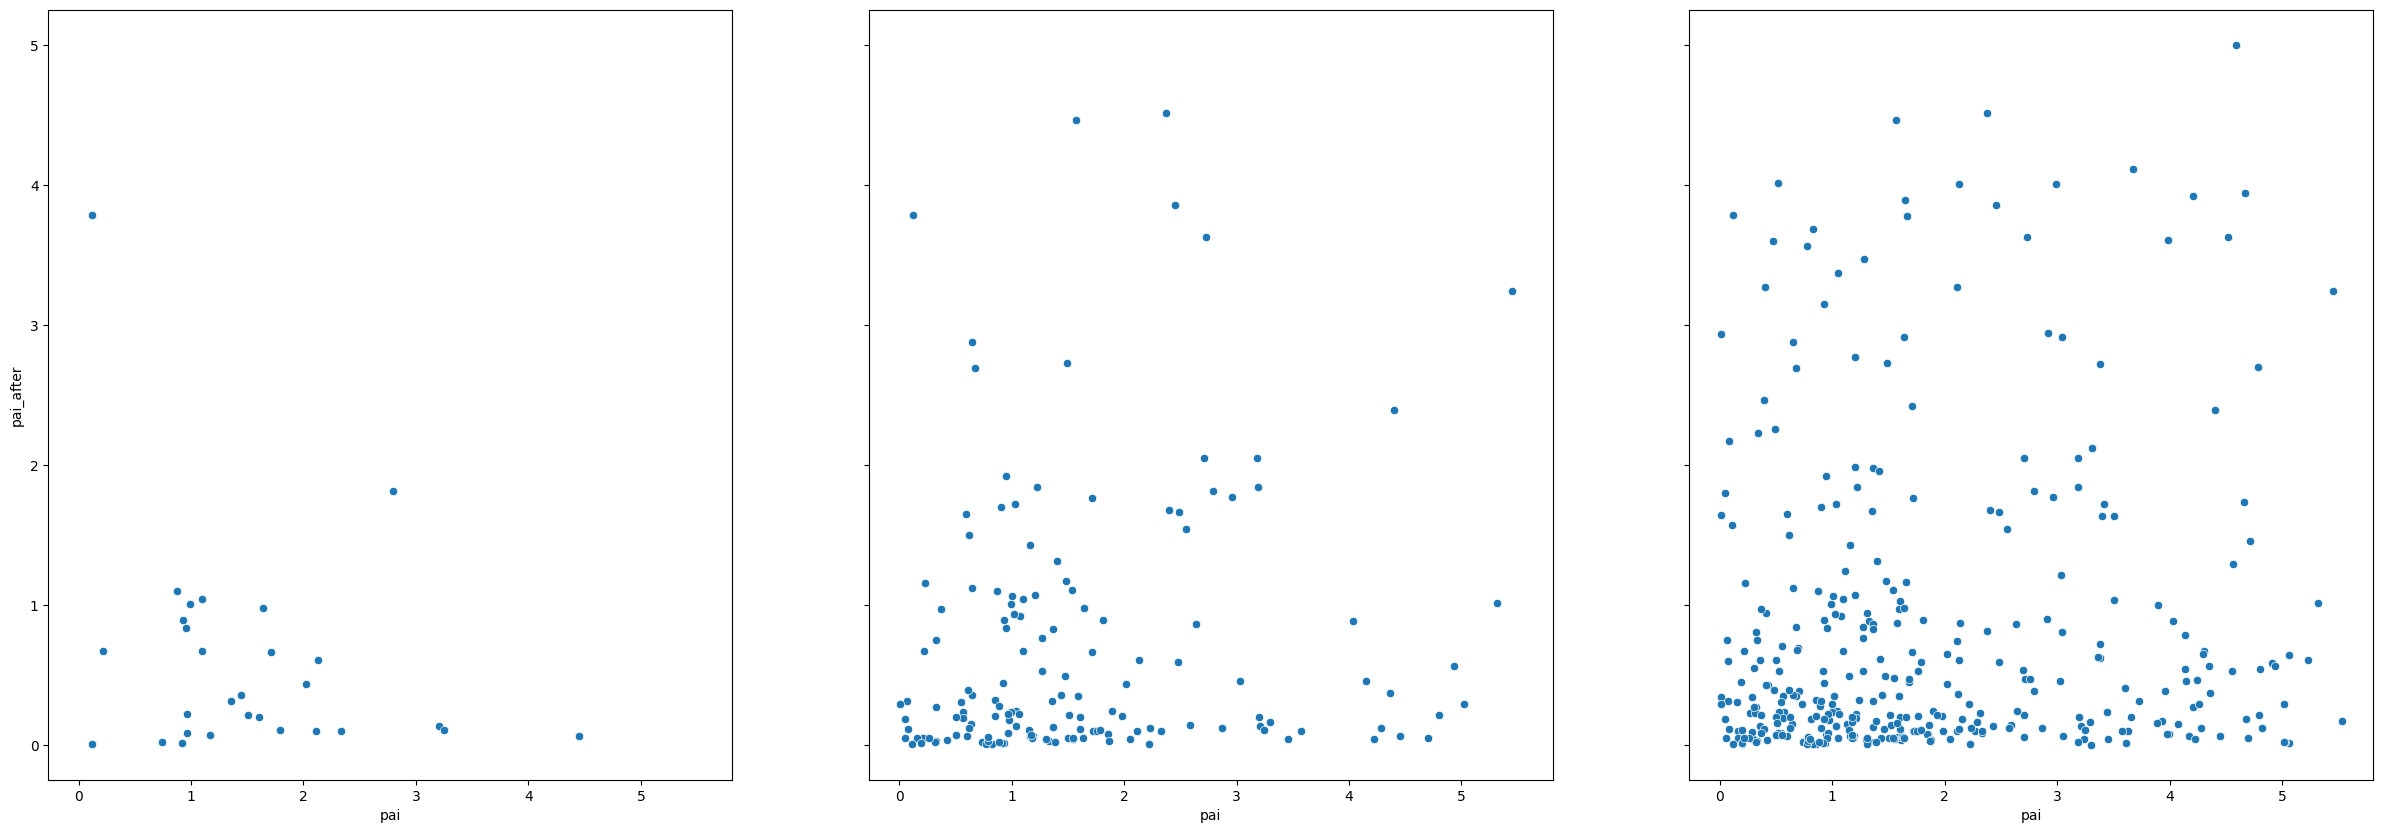

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
sns.scatterplot(get_closest_matches(high_severity, 10), x='pai', y='pai_after', ax=ax[0])
sns.scatterplot(get_closest_matches(high_severity, 20), x='pai', y='pai_after',  ax=ax[1])
sns.scatterplot(get_closest_matches(high_severity, 30), x='pai', y='pai_after',  ax=ax[2])

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


<Axes: >

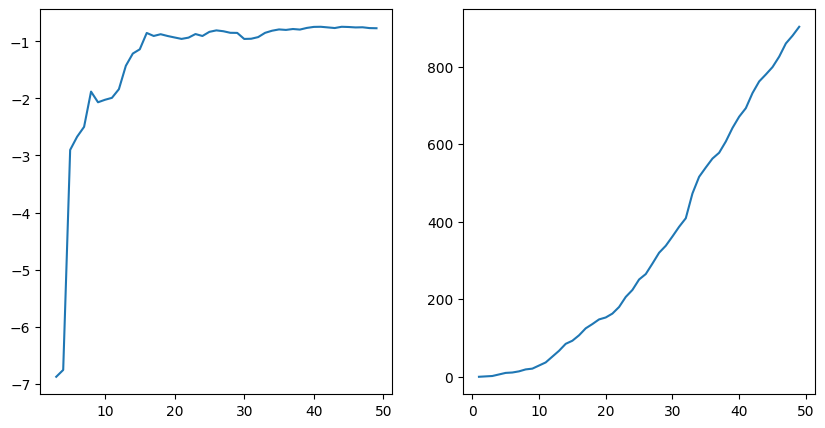

In [59]:
distances = range(1, 50)
r2s, num_matches = calculate_error_for_distances(high_severity, distances, 'pai', 'pai_after')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=distances, y=r2s, ax=ax[0])
sns.lineplot(x=distances, y=num_matches, ax=ax[1])

Best Linear regression coefficient is [0.1067075]. R squared is: 0.020342390421364986.
The error for coeff = 1 is: -0.9307139866753567.


<Axes: xlabel='pai', ylabel='pai_after'>

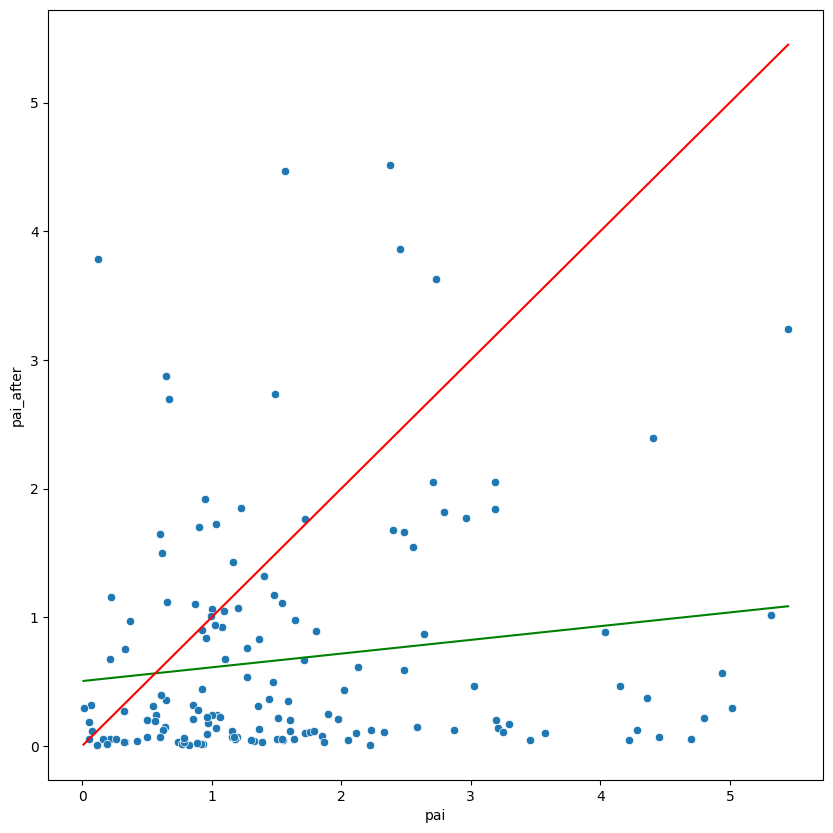

In [60]:
dist_10 = get_closest_matches(high_severity, 20)
reg_10 = LinearRegression().fit(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1)), dist_10.pai_after.values)
score = reg_10.score(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1)), dist_10.pai_after.values)
print(f'Best Linear regression coefficient is {reg_10.coef_}. R squared is: {score}.')

print(f'The error for coeff = 1 is: {r2_score(dist_10.pai.values, dist_10.pai_after.values)}.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(dist_10, x='pai', y='pai_after', ax=ax)
sns.lineplot(x=dist_10.pai.values, y=reg_10.predict(np.reshape(dist_10.pai.values, (dist_10.shape[0], 1))), color='green')
sns.lineplot(x=dist_10.pai.values, y=dist_10.pai.values, color='red')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,0.866318,587.652421,-771.491273,inf,0.064546,0.525602
lognorm,1.053577,572.501482,-746.580393,inf,0.089263,0.164322
gamma,1.058256,570.542380,-745.902486,inf,0.090664,0.151966
beta,1.059139,572.187775,-740.744387,inf,0.090937,0.149651
norm,1.091891,553.614923,-746.145672,inf,0.101831,0.078021


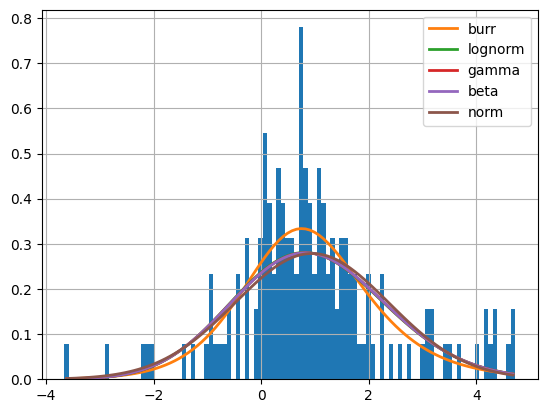

In [61]:
f = Fitter(get_closest_matches(high_severity, 20).pai_diff.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

f.fit()
f.summary()

In [62]:
# Fit normal
f = Fitter(get_closest_matches(high_severity, 20).pai_diff.values,
           distributions=["norm"])

f.fit()
#f.summary()
f.get_best(method = 'sumsquare_error')

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


{'norm': {'loc': 0.9432518141993464, 'scale': 1.4317021529268712}}

In [63]:
stats.wilcoxon(get_closest_matches(high_severity, 20).pai, get_closest_matches(high_severity, 20).pai_after)

WilcoxonResult(statistic=1704.0, pvalue=2.4265630551054697e-14)